In [511]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from IPython.display import clear_output as clr
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier as mlp 
import os
import numpy as np
import time
from IPython.display import clear_output as clr
from sklearn.neural_network import MLPClassifier as MLP

from mpl_toolkits.axes_grid1 import ImageGrid
torch.autograd.set_detect_anomaly(True)

In [493]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), '../data/MNIST'))):
    trainset = datasets.MNIST('../data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('../data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


In [520]:
class VaDE(nn.Module):
    
    def __init__(self):
        super(VaDE, self).__init__()
        
        self.D = 784
        self.K = 10
        self.latent_size = 14
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, self.latent_size)
        self.fc22 = nn.Linear(400, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, 400)
        self.fc4 = nn.Linear(400, 784)
        
        
        self.logpis = torch.nn.Parameter(torch.tensor([1/self.latent_size + np.random.rand()*10e-4  for i in range(self.K)]).log())
        self.mus = torch.nn.Parameter(torch.zeros((self.latent_size,self.K)))
        self.logvars = torch.nn.Parameter(torch.zeros((self.latent_size,self.K)))
        
        self.classifier = MLP()
        self.init_cla = True
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.D))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z
    
    def objective(self, recon_x, x, mu, logvar, z):
        N = x.shape[0]
        
        ### Calculating Gamma
        logpc = self.logpis#pc.log()
        qcgivenx = []
        eps = 10e-8
        
        for j in range(self.K):
            logvar_j = self.logvars[:,j] 
            means_j = self.mus[:,j]
            inv_variance_j = torch.diag(1/torch.exp(logvar_j)+eps)
            variance_j = torch.diag(torch.exp(logvar_j)+eps)
            diff_j = (z - means_j.view(1,self.latent_size)).view(N, 1, 1, self.latent_size)## N x K
            logpzgivenc = -0.5*logvar_j.sum() + (-0.5*torch.matmul(torch.matmul(diff_j, inv_variance_j.view(1,self.latent_size,
                            self.latent_size)),diff_j.permute(0,1,3,2))).view(N)
            qcgivenx.append((logpzgivenc + logpc[j]).view(N,1))

        temp = torch.cat(qcgivenx, dim = 1).view(N,self.K)
        gamma_unnorm = (temp - torch.max(temp)).exp()+eps
        gamma = (gamma_unnorm/gamma_unnorm.sum(1).view(N,1)).detach()
        
        KL_gauss = []
        KL_class = []
        for j in range(self.K):
            logvar_j = self.logvars[:,j].view(1,-1)
            mu_j = self.mus[:,j].view(1,-1)
            logpi_j = self.logpis[j]
            var1 = -((logvar_j + (logvar-logvar_j).exp() + (mu_j-mu)**2/(logvar_j.exp())).sum(1)*0.5*gamma[:,j]).view(N)
            KL_gauss.append(var1.sum().view(1,1))
            var2 = gamma[:,j]*(logpi_j - (gamma[:,j] + eps).log())
            KL_class.append(var2.sum().view(1,1))
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.D), reduction='sum')/N
        KLD = -(torch.sum(torch.cat(KL_class)) + torch.sum(torch.cat(KL_gauss)) + (1+logvar).sum()*0.5)/N
        print('Losses', BCE, KLD)
        return BCE + KLD
    
    def train(self, X_train):
        N = X_train.shape[0]
        data = X_train.view(-1,self.D)
        self.optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(data)
        loss = self.objective(recon_batch, data, mu, logvar, z)
        loss.backward()
        self.optimizer.step()
        with torch.no_grad():
            temp = (self.logpis.exp()/self.logpis.exp().sum() + 10e-8).log()
            self.logpis*=0
            self.logpis+=temp
            
        return loss.item()
    
    def train_classifier(self, Z_train, Y_train):
        if(self.init_cla):
            y_onehot = (np.arange(10) == Y_train[:,None]).astype(np.float32)
            self.classifier.partial_fit(Z_train, Y_train, classes = y_onehot)
            self.init_cla = False
        else:
            self.classifier.partial_fit(Z_train, Y_train)
            
    def score(self, X_train, Y_train):
        N = X_train.shape[0]
        data = X_train.view(-1,self.D)
        mu, logvar = self.encode(data)
        Z_train = self.reparameterize(mu, logvar)
        score = self.classifier.score(Z_train.view(N,-1).detach().numpy(), (np.arange(10) == Y_train[:,None]).astype(np.float32))
        return score

In [521]:
device = 'cpu'
model = VaDE()

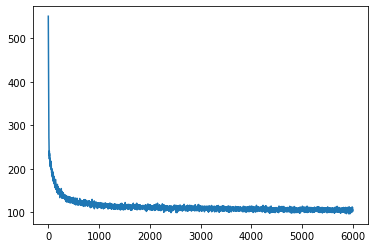

In [522]:
start = time.time()
train_loss = []
for epoch in range(10):
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        
        l = model.train(images)
        train_loss.append(l)
        
        if(i%1 == 0):
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1], ' time_e:', time.time() - start)
            clr(wait = True)
        
plt.plot(train_loss)
plt.show()

In [512]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

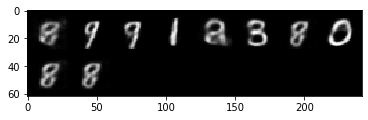

In [516]:
show_images(model.decode(model.mus.permute(1,0))[0:10].view(10,1,28,28).detach())

In [519]:
model.logpis.exp().sum()

tensor(140.5120, grad_fn=<SumBackward0>)